 Albina Chowdury, Cesar Cisneros, Estelle Hooper, Eva Ruse

# Dataset Creation
For our final project, we spent a substantial amount of time creating our datasets `spotify2019` and
`spotify2020`. First, we web scraped 40 of the [official Spotify top 200 chart webpages](https://spotifycharts.com/regional). Second, we used the Spotify API to gain Spotify-generated audio features of the songs we scraped from the charts. These audio features are numeric scores that rate a song's feature, such as danceability, valence, or loudness. 

This notebook documents our process of generating these datasets, explaining the code we wrote and the setbacks we faced.
<br><br>
Table of Contents
<br>
<a href='s1'>1. Introduction: Why did we decide to make our own dataset?</a>
<br>
<a href='s2'>2. Web Scraping</a>
<br>
<b><a href='s25'>2.5. PLEASE READ: Web Scraping - Issues (CloudFlare protection blocking our ability to web scrape) </a> </b>
<br>
<a href='s3'>3. Spotify API</a>
<br>

<a id='s1'></a>
### 1. Introduction: Why did we decide to make our own dataset?
#### Research Question: Is there a relationship between how happy a country is and the music the people of this country listen to?
When we first asked our main research question at the start of the semester we had planned on using this dataset on Kaggle: [Spotify's Worldwide Daily Song Ranking (2017)](https://www.kaggle.com/edumucelli/spotifys-worldwide-daily-song-ranking).
It contains the top 200 streamed songs per day each for 54 countries (almost 4,000,000 observations!), directly taken from the [official Spotify Charts website](https://spotifycharts.com/regional). This was the only dataset that we could find containing the top songs of several countries on Spotify.<br><br>
While we did begin to work with this Kaggle dataset, after becoming more comfortable with pandas and learning about web scraping, we decided that we could make a dataset from the charts ourselves that better suited our research question. By having access to later years' song data (not only 2017), we would be able to answer our research question with more relevant conclusions and do more statistical analyses. For example, in our final project we train a model using 2019 song data to predict a country's happiness score in 2020.

### 2. Web Scraping

On a page on https://spotifycharts.com , Spotify allows users to select a date and a country to see a table of the "Top 200", a ranking of the top 200 songs by number of streams (not "Viral 50", which ranks songs by user-sharing). The following functions will create a pandas DataFrame by scraping the table from this webpage. 

![Spotify Chart img](spotify_chart.jpg)

In [1]:
#relevant imports
import requests #package for http requests
import bs4 #package for html parsing
import numpy as np
import pandas as pd 
from datetime import timedelta, date
import cloudscraper #for bypassing Spotify cloudflare protection. explained in section 2.5

In [7]:
#the following two functions were taken from this website. we have modified them slightly
# https://gist.github.com/hktosun/d4f98488cb8f005214acd12296506f48

# It creates the list of links in 2019 we will web scrape from.
def create_links_2019(country):
    '''
    returns: an array of strings, which are 365 links to spotify charts for each day in 2020 for a specified country.
    parameter: a string. a country's ISO Alpha-2 country abbreviation. These are 2-letter internationally recognized codes.
    https://www.nationsonline.org/oneworld/country_code_list.html for a full list of ISO Alpha-2 country codes.
    eg. to get 365 links for the united states, call create_links_2019('us')
    '''
    start_date = date(2019, 1, 1)
    end_date = date(2019,12,31)
    links = []
    dates = daterange(start_date, end_date)
    for single_date in daterange(start_date, end_date):
        links.append('https://spotifycharts.com/regional/' + country + '/daily/' + single_date.strftime("%Y-%m-%d"))
    return(links)

# same as create_links_2019, but for 2020
def create_links_2020(country):
    '''
    returns: an array of strings, which are 364 links to spotify charts for each day in 2019 for a specified country.
    parameter: a string. a country's ISO Alpha-2 country abbreviation. These are 2-letter internationally recognized codes.
    https://www.nationsonline.org/oneworld/country_code_list.html for a full list of ISO Alpha-2 country codes.
    eg. to get 365 links for the united states, call create_links_2020('us')
    '''
    start_date = date(2020, 1, 1)
    end_date = date(2020,12,31)
    links = []
    dates = daterange(start_date, end_date)
    for single_date in daterange(start_date, end_date):
        links.append('https://spotifycharts.com/regional/' + country + '/daily/' + single_date.strftime("%Y-%m-%d"))
    return(links)

def daterange(start_date, end_date):
    '''
    helper function for create_links_2019 and create_links_2020
    returns: daterange object.
    parameters: a start date and end date in "%Y-%m-%d" format.
    '''
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [8]:
#demonstration of code
links_us=create_links_2019('us')
print(len(links_us))

364


using the pandas function `read_html()` and Beautiful Soup

In [8]:
def get_table(link):
    '''
    a function that returns a table of the top 50 songs from a spotify chart
    with the following columns:
    track. a string, "[track name] by [artist]"
    position. an int, the ranking of the track on the chart.
    streams. an int, # of streams of the track on a specified date.
    date. a date time obj. the day the song was streamed.
    url. a url to the song on Spotify.
    
    argument: a string, which is a link to a Spotify chart. eg. 'https://spotifycharts.com/regional/us/daily/2020-01-01'
    '''
    #getting the df
    scraper = cloudscraper.create_scraper()
    r = scraper.get(link)
    df_list = pd.read_html(r.text) # this parses all the tables in webpages to a lis
    df = df_list[0]
    #for the purposes of our project, we only want the top 50 songs of the table that was scraped from the
    #spotify website, which gives us top 200. we find that 200 songs per day was excessive
    df=df.head(50)

    #cleaning column names and dropping irrelevant columns
    #to lowercase
    cols= [x.lower() for x in df.columns] 
    df.columns=cols
    #after scraping, Spotify returns a column 'unnamed: 1', which is actually the position of the song on the chart.
    #which we have renamed
    df = df.rename(columns={'unnamed: 1': 'position'})
    #it also returns two NaN columns, which we drop here
    df=df.drop(columns=["unnamed: 0","unnamed: 2"])
    
    #adding a date column by parsing the link used in the argument.
    df["date"]=link[-10:]
    df['date']=pd.to_datetime(df['date'])
    
    #creating the url column
    #using Beautiful soup to webscrape the links on the site.
    datasoup = bs4.BeautifulSoup(r.text, 'html.parser')
    aList=[]
    #find all 'a' tags
    for data in datasoup.findAll('a'):
        aList.append(data)
    links=[]
    #find all href tags
    for x in aList:
        links.append(x.get('href'))
    #drop None types
    clean = filter(None, links)
    urls=[]
    #only keep the links that are links to spotify tracks.
    for x in clean:
        if 'open.spotify.com/track/' in x:
            urls.append(x)
    #only append the top 50 to the dataframe
    df['url']=urls[:50]
    return df

In [9]:
def track_artist(df):
    '''
    returns a df that takes "track" column, which contains both the artist and song. 
    it is a string formatted as "[track name] by [artist]"
    and parses it into 2 columns: track_name and artist.
    and deletes the track column after.
    
    argument: a dataframe created by get_table(), containing a column "track"
    with each observation a string formatted as "[track name] by [artist]"
    '''
    tracks=df.track.values
    songtitles=[]
    songartists=[]
    for song in tracks:
        index1=song.find("  by")
        index2=song.find("by ")
        track=song[:index1]
        songtitles.append(track)
        artist=song[index2+3:]
        songartists.append(artist)
    df["track_name"]=songtitles
    df["artist"]=songartists
    df=df.drop(columns=["track"])
    return df

In [7]:
allcountries=["United States", "United Kingdom", "United Arab Emirates", "Argentina", "Austria", "Australia", "Belgium", "Bulgaria", "Bolivia", "Brazil", "Canada", "Switzerland", "Chile", "Colombia", "Costa Rica", "Cyprus", "Czech Republic", "Germany", "Denmark", "Dominican Republic", "Ecuador", "Estonia", "Egypt", "Spain", "Finland", "France", "Greece", "Guatemala", "Hong Kong", "Honduras", "Hungary", "Indonesia", "Ireland", "Israel", "India", "Iceland", "Italy", "Japan", "Republic of Korea", "Lithuania", "Luxembourg", "Latvia", "Morocco", "Mexico", "Malaysia", "Nicaragua", "Netherlands", "Norway", "New Zealand", "Panama", "Peru", "Philippines", "Poland", "Portugal", "Paraguay", "Romania", "Russia", "Saudi Arabia", "Sweden", "Singapore", "Slovakia", "El Salvador", "Thailand", "Turkey", "Taiwan", "Ukraine", "Uruguay", "Vietnam", "South Africa"
]

In [10]:
happy2020=pd.read_csv("happiness2020.csv")
happy2020.head()

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267
3,Iceland,Western Europe,7.5045,0.059616,7.621347,7.387653,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,1.972317,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688
4,Norway,Western Europe,7.4880,0.034837,7.556281,7.419719,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,1.972317,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266


In [12]:
new

['Finland',
 'Denmark',
 'Switzerland',
 'Iceland',
 'Norway',
 'Netherlands',
 'Sweden',
 'New Zealand',
 'Austria',
 'Luxembourg',
 'Canada',
 'Australia',
 'United Kingdom',
 'Israel',
 'Costa Rica',
 'Ireland',
 'Germany',
 'United States',
 'Czech Republic',
 'Belgium',
 'United Arab Emirates',
 'France',
 'Mexico',
 'Uruguay',
 'Saudi Arabia',
 'Spain',
 'Guatemala',
 'Italy',
 'Singapore',
 'Brazil',
 'El Salvador',
 'Panama',
 'Slovakia',
 'Chile',
 'Lithuania',
 'Poland',
 'Colombia',
 'Cyprus',
 'Nicaragua',
 'Romania',
 'Estonia',
 'Philippines',
 'Hungary',
 'Thailand',
 'Argentina',
 'Honduras',
 'Latvia',
 'Ecuador',
 'Portugal',
 'Japan',
 'Peru',
 'Bolivia',
 'Paraguay',
 'Dominican Republic',
 'Russia',
 'Greece',
 'Malaysia',
 'Vietnam',
 'Indonesia',
 'Turkey',
 'Bulgaria',
 'Morocco',
 'South Africa',
 'Ukraine',
 'Egypt',
 'India']

In [11]:
cols2020= [x.lower() for x in happy2020.columns] 
cols2020= [x.replace(" ","_") for x in cols2020] 
happy2020.columns=cols2020
countries2020=happy2020.country_name.to_numpy()
new=[]
for x in countries2020:
    if x in allcountries:
        new.append(x)
topbot2020=new[:10]+new[-10:]
topbot2020

['Finland',
 'Denmark',
 'Switzerland',
 'Iceland',
 'Norway',
 'Netherlands',
 'Sweden',
 'New Zealand',
 'Austria',
 'Luxembourg',
 'Malaysia',
 'Vietnam',
 'Indonesia',
 'Turkey',
 'Bulgaria',
 'Morocco',
 'South Africa',
 'Ukraine',
 'Egypt',
 'India']

In [ ]:
# region_id2020=['fi','dk','ch','is','no','nl','se','nz','at','lu','my','vn','id','tr','bg','ma','za','ua','eg','in']

In [ ]:
# happy2017

In [ ]:
# region_id2017=['no', 'dk', 'ch', 'fi', 'nl', 'se', 'ee', 'hu', 'id', 'is', 'ca',
#        'nz', 'au', 'tr', 'py', 'ph', 'do', 'gy', 'pt', 'hn']

In [ ]:
# #Eva run this one
# spotify2017=pd.DataFrame()
# for region in region_id2017:
#     links=create_links_2017(region)
#     for link in links:
#         df=get_table(link)
#         df=track_artist(df)
#         df['region']=region
#         spotify2020=spotify2020.append(df,ignore_index=True)

In [ ]:
# #Estelle run this one
# spotify2020=pd.DataFrame()
# for region in region_id2020:
#     links=create_links_2020(region)
#     for link in links:
#         df=get_table(link)
#         df=track_artist(df)
#         df['region']=region
#         print(region)
#         spotify2020=spotify2020.append(df,ignore_index=True)
# spotify2020

In [12]:
norway2019.to_csv("norway2019.csv")

In [1]:
norway2019

NameError: name 'norway2019' is not defined

In [10]:
norway=create_links_2019("no")
norway2019=pd.DataFrame()

In [11]:
for link in norway:
    df=get_table(link)
    df=track_artist(df)
    df['region']="no"
    norway2019=norway2019.append(df,ignore_index=True)
    print(link)
norway2019

https://spotifycharts.com/regional/no/daily/2019-01-01
https://spotifycharts.com/regional/no/daily/2019-01-02
https://spotifycharts.com/regional/no/daily/2019-01-03
https://spotifycharts.com/regional/no/daily/2019-01-04
https://spotifycharts.com/regional/no/daily/2019-01-05
https://spotifycharts.com/regional/no/daily/2019-01-06
https://spotifycharts.com/regional/no/daily/2019-01-07
https://spotifycharts.com/regional/no/daily/2019-01-08
https://spotifycharts.com/regional/no/daily/2019-01-09
https://spotifycharts.com/regional/no/daily/2019-01-10
https://spotifycharts.com/regional/no/daily/2019-01-11
https://spotifycharts.com/regional/no/daily/2019-01-12
https://spotifycharts.com/regional/no/daily/2019-01-13
https://spotifycharts.com/regional/no/daily/2019-01-14
https://spotifycharts.com/regional/no/daily/2019-01-15
https://spotifycharts.com/regional/no/daily/2019-01-16
https://spotifycharts.com/regional/no/daily/2019-01-17
https://spotifycharts.com/regional/no/daily/2019-01-18
https://sp

,position,streams,date,url,track_name,artist,region
0,1,69663,2019-01-01,https://open.spotify.com/track/25sgk305KZfyuqV...,Sweet but Psycho,Ava Max,no
1,2,67916,2019-01-01,https://open.spotify.com/track/6MWtB6iiXyIwun0...,Wow.,Post Malone,no
2,3,56131,2019-01-01,https://open.spotify.com/track/0lG6QM1jjbbX5UU...,Lost Control,"Alan Walker, Sorana",no
3,4,53922,2019-01-01,https://open.spotify.com/track/2VxeLyX666F8uXC...,Shallow,"Lady Gaga, Bradley Cooper",no
4,5,53118,2019-01-01,https://open.spotify.com/track/0nrWZWkJM62ftQJ...,Diamond Heart,"Alan Walker, Sophia Somajo",no
...,...,...,...,...,...,...,...
18195,46,25397,2019-12-30,https://open.spotify.com/track/285pBltuF7vW8Te...,Lucid Dreams,Juice WRLD,no
18196,47,25119,2019-12-30,https://open.spotify.com/track/4AO1XhrgJczQ9bN...,WHAT TO DO? (feat. Don Toliver),"JACKBOYS, Travis Scott",no
18197,48,23253,2019-12-30,https://open.spotify.com/track/4QPEwDdOMhY7rNS...,Own It (feat. Ed Sheeran & Burna Boy),Stormzy,no
18198,49,22865,2019-12-30,https://open.spotify.com/track/6TmkOBZ2UEQaIWR...,Can I Be Forgiven,Highasakite,no


In [12]:
resume=create_links_2019("ca")
resume

['https://spotifycharts.com/regional/ca/daily/2019-09-02',
 'https://spotifycharts.com/regional/ca/daily/2019-09-03',
 'https://spotifycharts.com/regional/ca/daily/2019-09-04',
 'https://spotifycharts.com/regional/ca/daily/2019-09-05',
 'https://spotifycharts.com/regional/ca/daily/2019-09-06',
 'https://spotifycharts.com/regional/ca/daily/2019-09-07',
 'https://spotifycharts.com/regional/ca/daily/2019-09-08',
 'https://spotifycharts.com/regional/ca/daily/2019-09-09',
 'https://spotifycharts.com/regional/ca/daily/2019-09-10',
 'https://spotifycharts.com/regional/ca/daily/2019-09-11',
 'https://spotifycharts.com/regional/ca/daily/2019-09-12',
 'https://spotifycharts.com/regional/ca/daily/2019-09-13',
 'https://spotifycharts.com/regional/ca/daily/2019-09-14',
 'https://spotifycharts.com/regional/ca/daily/2019-09-15',
 'https://spotifycharts.com/regional/ca/daily/2019-09-16',
 'https://spotifycharts.com/regional/ca/daily/2019-09-17',
 'https://spotifycharts.com/regional/ca/daily/2019-09-18

In [ ]:
# region_id2020=['fi','dk','ch','is','no','nl','se','nz','at','lu','my','vn','id','tr','bg','ma','za','ua','eg','in']

In [15]:
finland=finland.drop(columns=["Unnamed: 0","Unnamed: 0.1"])

In [14]:
canada

,position,streams,date,url,track_name,artist,region
0,1,225280,2019-01-01,https://open.spotify.com/track/3KkXRkHbMCARz0a...,Sunflower - Spider-Man: Into the Spider-Verse,"Post Malone, Swae Lee",ca
1,2,210638,2019-01-01,https://open.spotify.com/track/6MWtB6iiXyIwun0...,Wow.,Post Malone,ca
2,3,196378,2019-01-01,https://open.spotify.com/track/2xLMifQCjDGFmkH...,SICKO MODE,Travis Scott,ca
3,4,195971,2019-01-01,https://open.spotify.com/track/2rPE9A1vEgShuZx...,"thank u, next",Ariana Grande,ca
4,5,157739,2019-01-01,https://open.spotify.com/track/2IRZnDFmlqMuOrY...,Going Bad (feat. Drake),Meek Mill,ca
...,...,...,...,...,...,...,...
18195,46,63595,2019-12-30,https://open.spotify.com/track/4vUmTMuQqjdnvlZ...,South of the Border (feat. Camila Cabello & Ca...,Ed Sheeran,ca
18196,47,63157,2019-12-30,https://open.spotify.com/track/2YpeDb67231RjR0...,Old Town Road - Remix,"Lil Nas X, Billy Ray Cyrus",ca
18197,48,62239,2019-12-30,https://open.spotify.com/track/6Hj9jySrnFppAI0...,Robbery,Juice WRLD,ca
18198,49,61424,2019-12-30,https://open.spotify.com/track/5a6pdCHlWS2ekOO...,July,Noah Cyrus,ca


In [28]:
norway2019.to_csv('norway2020.csv')

In [21]:
finland=pd.read_csv("finland2020.csv")
denmark=pd.read_csv("denmark2020.csv")
switzerland=pd.read_csv("switzerland2020.csv")
iceland=pd.read_csv("iceland2020.csv")
norway=pd.read_csv("norway2020.csv")
netherlands=pd.read_csv("netherlands2020.csv")
sweden=pd.read_csv("sweden2020.csv")
newzealand=pd.read_csv("newzealand2020.csv")
austria=pd.read_csv("austria2020.csv")
canada=pd.read_csv("canada2020.csv")

In [24]:
spotify2020=spotify2020.drop(columns=["Unnamed: 0"])

In [32]:
spotify2020

,position,streams,date,url,track_name,artist,region
0,1,39681,2020-01-01,https://open.spotify.com/track/0tc8HGXosQDC8TT...,Hei rakas,BEHM,fi
1,2,31179,2020-01-01,https://open.spotify.com/track/3eHkFrUUGYuwEgI...,Pintakaasulla,JVG,fi
2,3,30339,2020-01-01,https://open.spotify.com/track/4gEvvWYAF3yzv9h...,Luota Muhun,ibe,fi
3,4,30208,2020-01-01,https://open.spotify.com/track/0sf12qNH5qcw8qp...,Blinding Lights,The Weeknd,fi
4,5,28966,2020-01-01,https://open.spotify.com/track/1rgnBhdG2JDFTbY...,Dance Monkey,Tones And I,fi
...,...,...,...,...,...,...,...
182445,46,58237,2020-12-30,https://open.spotify.com/track/6f3Slt0GbA2bPZl...,The Business,Tiësto,ca
182446,47,57657,2020-12-30,https://open.spotify.com/track/7kDUspsoYfLkWnZ...,my ex's best friend (with blackbear),Machine Gun Kelly,ca
182447,48,57321,2020-12-30,https://open.spotify.com/track/21jGcNKet2qwijl...,Circles,Post Malone,ca
182448,49,57003,2020-12-30,https://open.spotify.com/track/0A1hoCfMLkiAgvh...,Body,Megan Thee Stallion,ca


In [22]:
spotify2020=pd.DataFrame()
spotify2020=spotify2020.append(finland,ignore_index=True)
spotify2020=spotify2020.append(denmark,ignore_index=True)
spotify2020=spotify2020.append(switzerland,ignore_index=True)
spotify2020=spotify2020.append(iceland,ignore_index=True)
spotify2020=spotify2020.append(norway,ignore_index=True)
spotify2020=spotify2020.append(netherlands,ignore_index=True)
spotify2020=spotify2020.append(sweden,ignore_index=True)
spotify2020=spotify2020.append(newzealand,ignore_index=True)
spotify2020=spotify2020.append(austria,ignore_index=True)
spotify2020=spotify2020.append(canada,ignore_index=True)

In [28]:
spotify2020.to_csv("topspotify2020.csv")

In [33]:
botspotify2020=pd.read_csv("botspotify2020.csv")

In [35]:
botspotify2020=botspotify2020.drop(columns=["Unnamed: 0"])

In [37]:
spotify2020=spotify2020.append(botspotify2020,ignore_index=True)

In [39]:
spotify2020.region.unique()

array(['fi', 'dk', 'ch', 'is', 'no', 'nl', 'se', 'nz', 'at', 'ca', 'do',
       'gr', 'my', 'vn', 'id', 'tr', 'ma', 'za', 'eg', 'in'], dtype=object)

In [40]:
spotify2020.to_csv("spotify2020.csv")

In [29]:
fi=pd.read_csv("finland2019.csv")

In [30]:
fi['country']="Finland"

In [31]:
fi['region']='fi'

In [34]:
fi.head()

,Unnamed: 0,position,streams,date,url,track_name,artist,region,country
0,0,1,33717,2019-01-01,https://open.spotify.com/track/6MWtB6iiXyIwun0...,Wow.,Post Malone,fi,Finland
1,1,2,29651,2019-01-01,https://open.spotify.com/track/25sgk305KZfyuqV...,Sweet but Psycho,Ava Max,fi,Finland
2,2,3,28329,2019-01-01,https://open.spotify.com/track/4RYtaqxjDJUOY2G...,Harmaa Rinne,Teflon Brothers,fi,Finland
3,3,4,23977,2019-01-01,https://open.spotify.com/track/2rPE9A1vEgShuZx...,"thank u, next",Ariana Grande,fi,Finland
4,4,5,22435,2019-01-01,https://open.spotify.com/track/00WO1oBxZcj9aBo...,Tavallinen,Keko Salata,fi,Finland


In [32]:
norway=pd.read_csv("norway2019.csv")

In [33]:
norway['country']="Norway"

In [35]:
norway.head()

,Unnamed: 0,position,streams,date,url,track_name,artist,region,country
0,0,1,69663,2019-01-01,https://open.spotify.com/track/25sgk305KZfyuqV...,Sweet but Psycho,Ava Max,no,Norway
1,1,2,67916,2019-01-01,https://open.spotify.com/track/6MWtB6iiXyIwun0...,Wow.,Post Malone,no,Norway
2,2,3,56131,2019-01-01,https://open.spotify.com/track/0lG6QM1jjbbX5UU...,Lost Control,"Alan Walker, Sorana",no,Norway
3,3,4,53922,2019-01-01,https://open.spotify.com/track/2VxeLyX666F8uXC...,Shallow,"Lady Gaga, Bradley Cooper",no,Norway
4,4,5,53118,2019-01-01,https://open.spotify.com/track/0nrWZWkJM62ftQJ...,Diamond Heart,"Alan Walker, Sophia Somajo",no,Norway


In [36]:
ice=pd.read_csv("iceland2019.csv")

In [37]:
ice['country']="Iceland"

In [38]:
ice.head()

,Unnamed: 0,position,streams,date,url,track_name,artist,region,country
0,0,1,5935,2019-01-01,https://open.spotify.com/track/1YC7llsHtz0ScDt...,Næsta,"JóiPé, Króli, GDRN, SZK",is,Iceland
1,1,2,4678,2019-01-01,https://open.spotify.com/track/4OSdc34FbsNO5Pm...,Upp Til Hópa,"Herra Hnetusmjör, Ingi Bauer",is,Iceland
2,2,3,4249,2019-01-01,https://open.spotify.com/track/2VxeLyX666F8uXC...,Shallow,"Lady Gaga, Bradley Cooper",is,Iceland
3,3,4,3643,2019-01-01,https://open.spotify.com/track/3KkXRkHbMCARz0a...,Sunflower - Spider-Man: Into the Spider-Verse,"Post Malone, Swae Lee",is,Iceland
4,4,5,3463,2019-01-01,https://open.spotify.com/track/6MWtB6iiXyIwun0...,Wow.,Post Malone,is,Iceland


In [40]:
nl=pd.read_csv("netherlands2019.csv")

In [41]:
nl['country']="Netherlands"

In [43]:
nl['region']="nl"

In [44]:
nl.head()

,Unnamed: 0,position,streams,date,url,track_name,artist,region,country
0,0,1,29206,2019-01-01,https://open.spotify.com/track/7KPGeiXWDsGEvFK...,Benzema,Capital Bra,nl,Netherlands
1,1,2,25261,2019-01-01,https://open.spotify.com/track/25sgk305KZfyuqV...,Sweet but Psycho,Ava Max,nl,Netherlands
2,2,3,20493,2019-01-01,https://open.spotify.com/track/0kLA41xkWzzYzMI...,HaifischNikez Allstars,"LX, Maxwell, Bonez MC, Gzuz, Sa4",nl,Netherlands
3,3,4,19556,2019-01-01,https://open.spotify.com/track/31Zs71Yb7YoPlFx...,Lelele,"Azet, Zuna",nl,Netherlands
4,4,5,19235,2019-01-01,https://open.spotify.com/track/1rqqCSm0Qe4I9rU...,High Hopes,Panic! At The Disco,nl,Netherlands


In [46]:
se=pd.read_csv('sweden2019.csv')

In [47]:
se['country']="Sweden"

In [48]:
se.head()

,Unnamed: 0,position,streams,date,url,track_name,artist,region,country
0,0,1,107539,2019-01-01,https://open.spotify.com/track/2VxeLyX666F8uXC...,Shallow,"Lady Gaga, Bradley Cooper",se,Sweden
1,1,2,89449,2019-01-01,https://open.spotify.com/track/6MWtB6iiXyIwun0...,Wow.,Post Malone,se,Sweden
2,2,3,77692,2019-01-01,https://open.spotify.com/track/25sgk305KZfyuqV...,Sweet but Psycho,Ava Max,se,Sweden
3,3,4,66542,2019-01-01,https://open.spotify.com/track/3EPXxR3ImUwfaya...,Be Alright,Dean Lewis,se,Sweden
4,4,5,65000,2019-01-01,https://open.spotify.com/track/2rPE9A1vEgShuZx...,"thank u, next",Ariana Grande,se,Sweden


In [49]:
nz=pd.read_csv("newzealand2019.csv")

In [50]:
nz['country']="New Zealand"

In [51]:
nz.head()

,Unnamed: 0,position,streams,date,url,track_name,artist,region,country
0,0,1,69663,2019-01-01,https://open.spotify.com/track/25sgk305KZfyuqV...,Sweet but Psycho,Ava Max,nz,New Zealand
1,1,2,67916,2019-01-01,https://open.spotify.com/track/6MWtB6iiXyIwun0...,Wow.,Post Malone,nz,New Zealand
2,2,3,56131,2019-01-01,https://open.spotify.com/track/0lG6QM1jjbbX5UU...,Lost Control,"Alan Walker, Sorana",nz,New Zealand
3,3,4,53922,2019-01-01,https://open.spotify.com/track/2VxeLyX666F8uXC...,Shallow,"Lady Gaga, Bradley Cooper",nz,New Zealand
4,4,5,53118,2019-01-01,https://open.spotify.com/track/0nrWZWkJM62ftQJ...,Diamond Heart,"Alan Walker, Sophia Somajo",nz,New Zealand


In [54]:
ca=pd.read_csv("canada2019.csv")

In [55]:
ca['country']="Canada"

In [56]:
ca.head()

,Unnamed: 0,position,streams,date,url,track_name,artist,region,country
0,0,1,225280,2019-01-01,https://open.spotify.com/track/3KkXRkHbMCARz0a...,Sunflower - Spider-Man: Into the Spider-Verse,"Post Malone, Swae Lee",ca,Canada
1,1,2,210638,2019-01-01,https://open.spotify.com/track/6MWtB6iiXyIwun0...,Wow.,Post Malone,ca,Canada
2,2,3,196378,2019-01-01,https://open.spotify.com/track/2xLMifQCjDGFmkH...,SICKO MODE,Travis Scott,ca,Canada
3,3,4,195971,2019-01-01,https://open.spotify.com/track/2rPE9A1vEgShuZx...,"thank u, next",Ariana Grande,ca,Canada
4,4,5,157739,2019-01-01,https://open.spotify.com/track/2IRZnDFmlqMuOrY...,Going Bad (feat. Drake),Meek Mill,ca,Canada


In [57]:
at=pd.read_csv("austria2019.csv")

In [61]:
at["region"]="at"

In [62]:
at.head()

,Unnamed: 0,position,streams,date,url,track_name,artist,region,country
0,0,1,28947,2019-01-01,https://open.spotify.com/track/7KPGeiXWDsGEvFK...,Benzema,Capital Bra,at,Austria
1,1,2,23541,2019-01-01,https://open.spotify.com/track/25sgk305KZfyuqV...,Sweet but Psycho,Ava Max,at,Austria
2,2,3,20801,2019-01-01,https://open.spotify.com/track/0kLA41xkWzzYzMI...,HaifischNikez Allstars,"LX, Maxwell, Bonez MC, Gzuz, Sa4",at,Austria
3,3,4,18443,2019-01-01,https://open.spotify.com/track/1rqqCSm0Qe4I9rU...,High Hopes,Panic! At The Disco,at,Austria
4,4,5,18017,2019-01-01,https://open.spotify.com/track/1IPRghUN3LFPNbC...,Baller los,MERO,at,Austria


In [69]:
spotifychart2019=pd.DataFrame()

In [161]:
i=pd.read_csv("india2019.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'india2019.csv'

In [160]:
i['country']='India'

NameError: name 'i' is not defined

In [157]:
s.head()

,Unnamed: 0,position,streams,date,url,track_name,artist,region,country
0,0,1,5433,2019-01-01,https://open.spotify.com/track/3KkXRkHbMCARz0a...,Sunflower - Spider-Man: Into the Spider-Verse,"Post Malone, Swae Lee",za,South Africa
1,1,2,4170,2019-01-01,https://open.spotify.com/track/2dpaYNEQHiRxtZb...,Happier,"Marshmello, Bastille",za,South Africa
2,2,3,4015,2019-01-01,https://open.spotify.com/track/7FGq80cy8juXBCD...,Eastside (with Halsey & Khalid),benny blanco,za,South Africa
3,3,4,3972,2019-01-01,https://open.spotify.com/track/6MWtB6iiXyIwun0...,Wow.,Post Malone,za,South Africa
4,4,5,3895,2019-01-01,https://open.spotify.com/track/5p7ujcrUXASCNwR...,Without Me,Halsey,za,South Africa


In [158]:
.to_csv("southafrica2019.csv")

In [159]:
spotifychart2019=spotifychart2019.append(s,ignore_index=True)
spotifychart2019

,Unnamed: 0,position,streams,date,url,track_name,artist,region,country
0,0,1,33717,2019-01-01,https://open.spotify.com/track/6MWtB6iiXyIwun0...,Wow.,Post Malone,fi,Finland
1,1,2,29651,2019-01-01,https://open.spotify.com/track/25sgk305KZfyuqV...,Sweet but Psycho,Ava Max,fi,Finland
2,2,3,28329,2019-01-01,https://open.spotify.com/track/4RYtaqxjDJUOY2G...,Harmaa Rinne,Teflon Brothers,fi,Finland
3,3,4,23977,2019-01-01,https://open.spotify.com/track/2rPE9A1vEgShuZx...,"thank u, next",Ariana Grande,fi,Finland
4,4,5,22435,2019-01-01,https://open.spotify.com/track/00WO1oBxZcj9aBo...,Tavallinen,Keko Salata,fi,Finland
...,...,...,...,...,...,...,...,...,...
363995,18195,46,3427,2019-12-30,https://open.spotify.com/track/3jjujdWJ72nww5e...,Adore You,Harry Styles,za,South Africa
363996,18196,47,3416,2019-12-30,https://open.spotify.com/track/72Yg5qdIqpTnXrN...,Dames,Biggy,za,South Africa
363997,18197,48,3413,2019-12-30,https://open.spotify.com/track/6XHVuErjQ4XNm6n...,No Guidance (feat. Drake),Chris Brown,za,South Africa
363998,18198,49,3407,2019-12-30,https://open.spotify.com/track/7h0d2h0fUmzbs7z...,HIGHEST IN THE ROOM (feat. ROSALÍA & Lil Baby)...,Travis Scott,za,South Africa


In [166]:
spotifychart2019.to_csv("spotifychart2019.csv")

In [164]:
spotifychart2019=spotifychart2019.drop(columns=['Unnamed: 0'])

In [252]:
spotifychart2019=pd.read_csv("spotifychart2019.csv")

In [168]:
#Spotify API
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import seaborn as sns
from sklearn.linear_model import LinearRegression as lr
cid='5decb5b36c3f4465a4aafb6bdf035e5d'
secret='dcc15f6bb7254c12bede09644e0fb24b'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager
                    =client_credentials_manager)

In [220]:
def getunique(dataframe):
    '''
    creates a dataframe containing the audio features of songs, all scores, which are floats. These audio features are provided by the Spotify API.
    parameters: a dataframe with a 'url' column, which contains valid links to a song on Spotify.
    returns: a dataframe with the audio features as columns, the observations being
    ONLY for the unique songs in the provided dataframe. Because the dataframe contains several repeated songs,
    we will avoid calling the API on duplicated songs because we will get a "max entries error"
    '''
    audiofeatures=pd.DataFrame({'danceability':[], 'energy':[],'key':[], 'loudness':[], 'mode':[], 'speechiness':[],'acousticness':[], 'instrumentalness':[],'liveness':[], 'valence':[], 'tempo':[], 'type':[],'id':[], 'uri':[],'track_href':[], 'analysis_url':[], 'duration_ms':[], 'time_signature':[]})
    dataframe.drop_duplicates(subset ="track_name",
                     keep = 'first', inplace = True,) #drop duplicate songs
    dataframe=dataframe.reset_index(drop=True)
#     dataframe['track_name']
#     uniquesongs=pd.unique(dataframe['track_name'])
#     list=[]
        
    for row in range(len(dataframe)):
#          for song in uniquesongs:
#             if dataframe.loc[row,'track_name']==song and not song in list:
            url=dataframe.loc[row,'url']
            sub=url.rindex('/')
            idurl=url[sub+1:]
            newrow=sp.audio_features(idurl)[0]
            audiofeatures=audiofeatures.append(newrow,ignore_index=True)
#             list.append(song)
    audiofeatures['track_name']=dataframe['track_name']
    audiofeatures['happiness_score']=dataframe['happiness_score']
    audiofeatures['happiness_rank']=dataframe['happiness_rank']
    audiofeatures['country']=dataframe['country']
    return audiofeatures

In [181]:
uniquesongs2019=spotifychart2019.track_name.unique()

In [184]:
uniquesongs2019

array(['Wow.', 'Sweet but Psycho', 'Harmaa Rinne', ..., 'Fire',
       'Umona (feat. Mpumi)', 'Sandton'], dtype=object)

In [214]:
# spotifychart2019copy=spotifychart2019.copy()

In [189]:
test.head()

,position,streams,date,url,track_name,artist,region,country
0,1,33717,2019-01-01,https://open.spotify.com/track/6MWtB6iiXyIwun0...,Wow.,Post Malone,fi,Finland
1,2,29651,2019-01-01,https://open.spotify.com/track/25sgk305KZfyuqV...,Sweet but Psycho,Ava Max,fi,Finland
2,3,28329,2019-01-01,https://open.spotify.com/track/4RYtaqxjDJUOY2G...,Harmaa Rinne,Teflon Brothers,fi,Finland
3,4,23977,2019-01-01,https://open.spotify.com/track/2rPE9A1vEgShuZx...,"thank u, next",Ariana Grande,fi,Finland
4,5,22435,2019-01-01,https://open.spotify.com/track/00WO1oBxZcj9aBo...,Tavallinen,Keko Salata,fi,Finland


In [306]:
uniquesongs2019=spotifychart2019.copy().drop_duplicates(subset=['track_name'])

In [290]:
happy2019=pd.read_csv("2019.csv")

In [291]:
happy2019.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


In [292]:
cols2019= [x.lower() for x in happy2019.columns] 
cols2019= [x.replace(" ","_") for x in cols2019] 
happy2019.columns=cols2019
happy2019=happy2019.loc[happy2019['country_or_region'].isin(['Finland', 'Denmark', 'Norway', 'Iceland', 'Netherlands',
       'Switzerland', 'Sweden', 'New Zealand', 'Canada', 'Austria',
       'Portugal', 'Philippines', 'Hong Kong', 'Dominican Republic',
       'Turkey', 'Malaysia', 'Greece', 'Indonesia', 'Vietnam',
       'South Africa'])]

In [293]:
happy2019=happy2019.reset_index(drop=True)

In [294]:
happy2019=happy2019[['overall_rank','country_or_region','score']]

In [301]:
happy2019=happy2019.rename(columns={"overall_rank": "happiness_rank", "country_or_region": "country", "score": "happiness_score"})

In [313]:
happy2019.to_csv("happy2019.csv")

In [ ]:
happy2019we

In [307]:
gah=uniquesongs2019.merge(happy2019[['happiness_rank','country','happiness_score']], how="left",on='country')

In [238]:
ugh=pd.read_csv("philippines2019.csv")

In [244]:
ugh['country']="Philippines"

In [308]:
gah

,position,streams,date,url,track_name,artist,region,country,happiness_rank,happiness_score
0,1,33717,2019-01-01,https://open.spotify.com/track/6MWtB6iiXyIwun0...,Wow.,Post Malone,fi,Finland,1,7.769
1,2,29651,2019-01-01,https://open.spotify.com/track/25sgk305KZfyuqV...,Sweet but Psycho,Ava Max,fi,Finland,1,7.769
2,3,28329,2019-01-01,https://open.spotify.com/track/4RYtaqxjDJUOY2G...,Harmaa Rinne,Teflon Brothers,fi,Finland,1,7.769
3,4,23977,2019-01-01,https://open.spotify.com/track/2rPE9A1vEgShuZx...,"thank u, next",Ariana Grande,fi,Finland,1,7.769
4,5,22435,2019-01-01,https://open.spotify.com/track/00WO1oBxZcj9aBo...,Tavallinen,Keko Salata,fi,Finland,1,7.769
...,...,...,...,...,...,...,...,...,...,...
4056,48,3108,2019-12-02,https://open.spotify.com/track/1E8jmVFDwAWbDzs...,Lorch,"Kabza De Small, DJ Maphorisa, Semi Tee, Miano,...",za,South Africa,106,4.722
4057,38,3585,2019-12-07,https://open.spotify.com/track/5F6tLUQGd7GtiWI...,Jerusalema,"Master KG, Nomcebo Zikode",za,South Africa,106,4.722
4058,49,3315,2019-12-07,https://open.spotify.com/track/2nVAnGGOKDTzCw5...,Fire,"DJ Big Sky, LuuDeDeejay, Sbhanga",za,South Africa,106,4.722
4059,50,3372,2019-12-14,https://open.spotify.com/track/2cV1UhvhumluPGf...,Umona (feat. Mpumi),TNS,za,South Africa,106,4.722


In [258]:
top=spotifychart2019.iloc[:200200]
bot=spotifychart2019.iloc[218400:]

In [260]:
bot

,Unnamed: 0,position,streams,date,url,track_name,artist,region,country
218400,218400,1,12149,2019-01-01,https://open.spotify.com/track/3KkXRkHbMCARz0a...,Sunflower - Spider-Man: Into the Spider-Verse,"Post Malone, Swae Lee",hk,Hong Kong
218401,218401,2,11731,2019-01-01,https://open.spotify.com/track/2rPE9A1vEgShuZx...,"thank u, next",Ariana Grande,hk,Hong Kong
218402,218402,3,10156,2019-01-01,https://open.spotify.com/track/1SO5RyYJZUAI0aH...,Everything I Need (From Aquaman: Original Moti...,Skylar Grey,hk,Hong Kong
218403,218403,4,8714,2019-01-01,https://open.spotify.com/track/3ayrHkyorPEpeOB...,有一種悲傷 - 電影《比悲傷更悲傷的故事》主題曲,A-Lin,hk,Hong Kong
218404,218404,5,8334,2019-01-01,https://open.spotify.com/track/5p7ujcrUXASCNwR...,Without Me,Halsey,hk,Hong Kong
...,...,...,...,...,...,...,...,...,...
363995,363995,46,3427,2019-12-30,https://open.spotify.com/track/3jjujdWJ72nww5e...,Adore You,Harry Styles,za,South Africa
363996,363996,47,3416,2019-12-30,https://open.spotify.com/track/72Yg5qdIqpTnXrN...,Dames,Biggy,za,South Africa
363997,363997,48,3413,2019-12-30,https://open.spotify.com/track/6XHVuErjQ4XNm6n...,No Guidance (feat. Drake),Chris Brown,za,South Africa
363998,363998,49,3407,2019-12-30,https://open.spotify.com/track/7h0d2h0fUmzbs7z...,HIGHEST IN THE ROOM (feat. ROSALÍA & Lil Baby)...,Travis Scott,za,South Africa


In [261]:
top=top.append(ugh,ignore_index=True)

In [262]:
spotifychart2019=top.append(bot, ignore_index=True)

In [268]:
spotifychart2019=spotifychart2019.drop(columns=['Unnamed: 0.1'])

In [270]:
spotifychart2019.to_csv("spotifychart2019.csv")

In [309]:
songdata2019=getunique(gah)

In [310]:
spotify2019=spotifychart2019.merge(song[['danceability','track_name' ,'happiness_score', 'happiness_rank', 'energy', 'key', 'loudness', 'mode', 'speechiness',
'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'id', 'duration_ms']], how="left",on='track_name')

In [311]:
spotify2019

,position,streams,date,url,track_name,artist,region,country,danceability,happiness_score,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms
0,1,33717,2019-01-01,https://open.spotify.com/track/6MWtB6iiXyIwun0...,Wow.,Post Malone,fi,Finland,0.833,7.769,...,-7.399,0.0,0.1780,0.16300,0.000002,0.1010,0.385,99.947,6MWtB6iiXyIwun0YzU6DFP,149520.0
1,2,29651,2019-01-01,https://open.spotify.com/track/25sgk305KZfyuqV...,Sweet but Psycho,Ava Max,fi,Finland,0.719,7.769,...,-4.724,1.0,0.0476,0.06910,0.000000,0.1660,0.628,133.002,25sgk305KZfyuqVBQIahim,187436.0
2,3,28329,2019-01-01,https://open.spotify.com/track/4RYtaqxjDJUOY2G...,Harmaa Rinne,Teflon Brothers,fi,Finland,0.861,7.769,...,-5.862,0.0,0.1650,0.04100,0.000000,0.1500,0.962,129.933,4RYtaqxjDJUOY2GrtkLTFf,170886.0
3,4,23977,2019-01-01,https://open.spotify.com/track/2rPE9A1vEgShuZx...,"thank u, next",Ariana Grande,fi,Finland,0.724,7.769,...,-5.642,1.0,0.0658,0.28000,0.000000,0.1020,0.435,106.960,2rPE9A1vEgShuZxxzR2tZH,207333.0
4,5,22435,2019-01-01,https://open.spotify.com/track/00WO1oBxZcj9aBo...,Tavallinen,Keko Salata,fi,Finland,0.803,7.769,...,-7.928,0.0,0.0564,0.67300,0.000010,0.1330,0.404,112.964,00WO1oBxZcj9aBoeiODXDx,231791.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363995,46,3427,2019-12-30,https://open.spotify.com/track/3jjujdWJ72nww5e...,Adore You,Harry Styles,za,South Africa,0.676,7.769,...,-3.675,1.0,0.0483,0.02370,0.000007,0.1020,0.569,99.048,1M4qEo4HE3PRaCOM7EXNJq,207133.0
363996,47,3416,2019-12-30,https://open.spotify.com/track/72Yg5qdIqpTnXrN...,Dames,Biggy,za,South Africa,0.912,4.722,...,-7.984,1.0,0.2260,0.10300,0.000006,0.3580,0.637,122.024,72Yg5qdIqpTnXrNPEewglz,217879.0
363997,48,3413,2019-12-30,https://open.spotify.com/track/6XHVuErjQ4XNm6n...,No Guidance (feat. Drake),Chris Brown,za,South Africa,0.698,7.600,...,-6.756,0.0,0.1510,0.12300,0.000000,0.1550,0.137,92.932,7FEwp8BavoEVE3AnxJDchc,260640.0
363998,49,3407,2019-12-30,https://open.spotify.com/track/7h0d2h0fUmzbs7z...,HIGHEST IN THE ROOM (feat. ROSALÍA & Lil Baby)...,Travis Scott,za,South Africa,0.559,7.769,...,-6.406,0.0,0.0346,0.05670,0.000000,0.0992,0.114,153.131,7h0d2h0fUmzbs7zeFigJPn,244874.0


In [314]:
spotify2019

,position,streams,date,url,track_name,artist,region,country,danceability,happiness_score,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms
0,1,33717,2019-01-01,https://open.spotify.com/track/6MWtB6iiXyIwun0...,Wow.,Post Malone,fi,Finland,0.833,7.769,...,-7.399,0.0,0.1780,0.16300,0.000002,0.1010,0.385,99.947,6MWtB6iiXyIwun0YzU6DFP,149520.0
1,2,29651,2019-01-01,https://open.spotify.com/track/25sgk305KZfyuqV...,Sweet but Psycho,Ava Max,fi,Finland,0.719,7.769,...,-4.724,1.0,0.0476,0.06910,0.000000,0.1660,0.628,133.002,25sgk305KZfyuqVBQIahim,187436.0
2,3,28329,2019-01-01,https://open.spotify.com/track/4RYtaqxjDJUOY2G...,Harmaa Rinne,Teflon Brothers,fi,Finland,0.861,7.769,...,-5.862,0.0,0.1650,0.04100,0.000000,0.1500,0.962,129.933,4RYtaqxjDJUOY2GrtkLTFf,170886.0
3,4,23977,2019-01-01,https://open.spotify.com/track/2rPE9A1vEgShuZx...,"thank u, next",Ariana Grande,fi,Finland,0.724,7.769,...,-5.642,1.0,0.0658,0.28000,0.000000,0.1020,0.435,106.960,2rPE9A1vEgShuZxxzR2tZH,207333.0
4,5,22435,2019-01-01,https://open.spotify.com/track/00WO1oBxZcj9aBo...,Tavallinen,Keko Salata,fi,Finland,0.803,7.769,...,-7.928,0.0,0.0564,0.67300,0.000010,0.1330,0.404,112.964,00WO1oBxZcj9aBoeiODXDx,231791.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363995,46,3427,2019-12-30,https://open.spotify.com/track/3jjujdWJ72nww5e...,Adore You,Harry Styles,za,South Africa,0.676,7.769,...,-3.675,1.0,0.0483,0.02370,0.000007,0.1020,0.569,99.048,1M4qEo4HE3PRaCOM7EXNJq,207133.0
363996,47,3416,2019-12-30,https://open.spotify.com/track/72Yg5qdIqpTnXrN...,Dames,Biggy,za,South Africa,0.912,4.722,...,-7.984,1.0,0.2260,0.10300,0.000006,0.3580,0.637,122.024,72Yg5qdIqpTnXrNPEewglz,217879.0
363997,48,3413,2019-12-30,https://open.spotify.com/track/6XHVuErjQ4XNm6n...,No Guidance (feat. Drake),Chris Brown,za,South Africa,0.698,7.600,...,-6.756,0.0,0.1510,0.12300,0.000000,0.1550,0.137,92.932,7FEwp8BavoEVE3AnxJDchc,260640.0
363998,49,3407,2019-12-30,https://open.spotify.com/track/7h0d2h0fUmzbs7z...,HIGHEST IN THE ROOM (feat. ROSALÍA & Lil Baby)...,Travis Scott,za,South Africa,0.559,7.769,...,-6.406,0.0,0.0346,0.05670,0.000000,0.0992,0.114,153.131,7h0d2h0fUmzbs7zeFigJPn,244874.0


In [324]:
top=spotify2019.iloc[:182000]

In [328]:
bot=spotify2019.iloc[182000:]

In [337]:
top['rank']=0
top

<ipython-input-337-3be4f6576b26>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top['rank']=0


,position,streams,date,url,track_name,artist,region,country,danceability,happiness_score,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,rank
0,1,33717,2019-01-01,https://open.spotify.com/track/6MWtB6iiXyIwun0...,Wow.,Post Malone,fi,Finland,0.833,7.769,...,0.0,0.1780,0.1630,0.000002,0.101,0.385,99.947,6MWtB6iiXyIwun0YzU6DFP,149520.0,0
1,2,29651,2019-01-01,https://open.spotify.com/track/25sgk305KZfyuqV...,Sweet but Psycho,Ava Max,fi,Finland,0.719,7.769,...,1.0,0.0476,0.0691,0.000000,0.166,0.628,133.002,25sgk305KZfyuqVBQIahim,187436.0,0
2,3,28329,2019-01-01,https://open.spotify.com/track/4RYtaqxjDJUOY2G...,Harmaa Rinne,Teflon Brothers,fi,Finland,0.861,7.769,...,0.0,0.1650,0.0410,0.000000,0.150,0.962,129.933,4RYtaqxjDJUOY2GrtkLTFf,170886.0,0
3,4,23977,2019-01-01,https://open.spotify.com/track/2rPE9A1vEgShuZx...,"thank u, next",Ariana Grande,fi,Finland,0.724,7.769,...,1.0,0.0658,0.2800,0.000000,0.102,0.435,106.960,2rPE9A1vEgShuZxxzR2tZH,207333.0,0
4,5,22435,2019-01-01,https://open.spotify.com/track/00WO1oBxZcj9aBo...,Tavallinen,Keko Salata,fi,Finland,0.803,7.769,...,0.0,0.0564,0.6730,0.000010,0.133,0.404,112.964,00WO1oBxZcj9aBoeiODXDx,231791.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181995,46,9343,2019-12-30,https://open.spotify.com/track/5sMugAU31Ug5SAU...,Eiskalt,"Loredana, Mozzik",at,Austria,0.798,7.488,...,1.0,0.1400,0.0274,0.000065,0.106,0.677,180.014,52UVKsw31NTOCTNPTpwbFJ,151558.0,0
181996,47,9206,2019-12-30,https://open.spotify.com/track/0TId5TSbdcBP32h...,Stars,"VIZE, Laniia",at,Austria,0.617,7.246,...,1.0,0.1100,0.0292,0.000000,0.160,0.345,127.878,0TId5TSbdcBP32haUV4Aet,165469.0,0
181997,48,9155,2019-12-30,https://open.spotify.com/track/3Dkfcd3DbXGVmM0...,CASINO ROYAL,"Kianush, PA Sports",at,Austria,0.754,7.246,...,0.0,0.2240,0.3450,0.000000,0.153,0.499,118.008,3Dkfcd3DbXGVmM05KCRuFA,171356.0,0
181998,49,8859,2019-12-30,https://open.spotify.com/track/6AFIVhbJLR7YVvW...,Huracan,"Samra, Capital Bra",at,Austria,0.681,7.488,...,0.0,0.4420,0.3880,0.000000,0.132,0.518,170.072,6AFIVhbJLR7YVvW9fLFMu1,182238.0,0


In [338]:
bot['rank']=1

<ipython-input-338-1c8bbe3eec85>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bot['rank']=1


In [339]:
spotify2019=top.append(bot,ignore_index=True)

In [341]:
spotify2019.to_csv('spotify2019.csv')

In [340]:
spotify2019

,position,streams,date,url,track_name,artist,region,country,danceability,happiness_score,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,rank
0,1,33717,2019-01-01,https://open.spotify.com/track/6MWtB6iiXyIwun0...,Wow.,Post Malone,fi,Finland,0.833,7.769,...,0.0,0.1780,0.16300,0.000002,0.1010,0.385,99.947,6MWtB6iiXyIwun0YzU6DFP,149520.0,0
1,2,29651,2019-01-01,https://open.spotify.com/track/25sgk305KZfyuqV...,Sweet but Psycho,Ava Max,fi,Finland,0.719,7.769,...,1.0,0.0476,0.06910,0.000000,0.1660,0.628,133.002,25sgk305KZfyuqVBQIahim,187436.0,0
2,3,28329,2019-01-01,https://open.spotify.com/track/4RYtaqxjDJUOY2G...,Harmaa Rinne,Teflon Brothers,fi,Finland,0.861,7.769,...,0.0,0.1650,0.04100,0.000000,0.1500,0.962,129.933,4RYtaqxjDJUOY2GrtkLTFf,170886.0,0
3,4,23977,2019-01-01,https://open.spotify.com/track/2rPE9A1vEgShuZx...,"thank u, next",Ariana Grande,fi,Finland,0.724,7.769,...,1.0,0.0658,0.28000,0.000000,0.1020,0.435,106.960,2rPE9A1vEgShuZxxzR2tZH,207333.0,0
4,5,22435,2019-01-01,https://open.spotify.com/track/00WO1oBxZcj9aBo...,Tavallinen,Keko Salata,fi,Finland,0.803,7.769,...,0.0,0.0564,0.67300,0.000010,0.1330,0.404,112.964,00WO1oBxZcj9aBoeiODXDx,231791.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363995,46,3427,2019-12-30,https://open.spotify.com/track/3jjujdWJ72nww5e...,Adore You,Harry Styles,za,South Africa,0.676,7.769,...,1.0,0.0483,0.02370,0.000007,0.1020,0.569,99.048,1M4qEo4HE3PRaCOM7EXNJq,207133.0,1
363996,47,3416,2019-12-30,https://open.spotify.com/track/72Yg5qdIqpTnXrN...,Dames,Biggy,za,South Africa,0.912,4.722,...,1.0,0.2260,0.10300,0.000006,0.3580,0.637,122.024,72Yg5qdIqpTnXrNPEewglz,217879.0,1
363997,48,3413,2019-12-30,https://open.spotify.com/track/6XHVuErjQ4XNm6n...,No Guidance (feat. Drake),Chris Brown,za,South Africa,0.698,7.600,...,0.0,0.1510,0.12300,0.000000,0.1550,0.137,92.932,7FEwp8BavoEVE3AnxJDchc,260640.0,1
363998,49,3407,2019-12-30,https://open.spotify.com/track/7h0d2h0fUmzbs7z...,HIGHEST IN THE ROOM (feat. ROSALÍA & Lil Baby)...,Travis Scott,za,South Africa,0.559,7.769,...,0.0,0.0346,0.05670,0.000000,0.0992,0.114,153.131,7h0d2h0fUmzbs7zeFigJPn,244874.0,1


In [344]:
avg=spotify2019.groupby('country').mean()

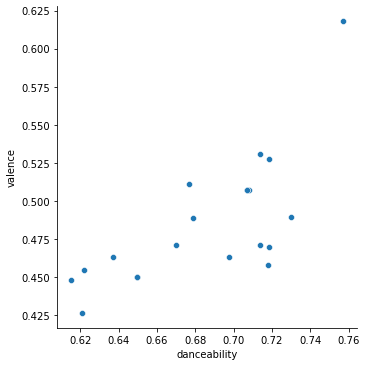

In [346]:
scatter=sns.relplot(x='danceability', y='valence', data=avg)